In [1]:
from bayesian_optimization import BayesianOptimization
import pandas as pd 
from botorch.test_functions import Hartmann
from varstool import DVARS
import seaborn as sns
import matplotlib.pyplot as plt

# Variables that determine the size of the dataset
N_INITIAL = 50
EPOCHS = 10
BATCH_SIZE = 5
DIM = 6
LOWER = 0
UPPER = 1

optimizer = BayesianOptimization(fun=Hartmann(dim=DIM,negate=True), 
                                 batch_size=BATCH_SIZE, 
                                 dim=DIM, 
                                 epochs=EPOCHS, 
                                 n_init=N_INITIAL, 
                                 lower_bound=LOWER,
                                 upper_bound=UPPER,
                                 seed=3,
                                 acqf_type='qUCB')

x_max, y_max = optimizer.run()
data = optimizer.get_data()
full = optimizer.format(data, dim=DIM, n_init=N_INITIAL, batch_size=BATCH_SIZE, epochs=EPOCHS)
display(full)

vars_data = full.drop(columns=['Batch'])

display(vars_data)
vars_data.to_csv('vars_data.csv', index=False)
h = 0.5
experiment = DVARS(data_file = 'vars_data.csv',
                   outvarname = 'y',
                   ivars_range = h,
                   phi0=1,
                   phi_max=1e6,
                   tol = 1e-6,
                   correlation_func_type='linear',
                   report_verbose=False)

experiment.run()
display(experiment.ratios)

/Users/dylanschubert/anaconda3/envs/msc_project/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


,Batch,x1,x2,x3,x4,x5,x6,y
0,0.0,0.068465,0.224527,0.699185,0.062586,0.375395,0.030421,0.088574
1,0.0,0.970500,0.746392,0.359620,0.621936,0.636389,0.987677,0.004567
2,0.0,0.660078,0.302549,0.864837,0.442916,0.830821,0.529411,0.014752
3,0.0,0.254129,0.793377,0.201296,0.993412,0.086961,0.486675,0.022586
4,0.0,0.444528,0.398969,0.495360,0.784879,0.225295,0.203210,0.242218
...,...,...,...,...,...,...,...,...
95,10.0,0.379502,0.601143,0.602907,0.914232,0.844984,0.996655,0.008648
96,10.0,0.034904,0.691495,0.634610,0.978683,0.470061,0.606510,0.026575
97,10.0,0.910413,0.972808,0.939009,0.738963,0.632248,0.959977,0.004637
98,10.0,0.185278,0.113426,0.520162,0.399648,0.326144,0.665813,2.838089


,x1,x2,x3,x4,x5,x6,y
0,0.068465,0.224527,0.699185,0.062586,0.375395,0.030421,0.088574
1,0.970500,0.746392,0.359620,0.621936,0.636389,0.987677,0.004567
2,0.660078,0.302549,0.864837,0.442916,0.830821,0.529411,0.014752
3,0.254129,0.793377,0.201296,0.993412,0.086961,0.486675,0.022586
4,0.444528,0.398969,0.495360,0.784879,0.225295,0.203210,0.242218
...,...,...,...,...,...,...,...
95,0.379502,0.601143,0.602907,0.914232,0.844984,0.996655,0.008648
96,0.034904,0.691495,0.634610,0.978683,0.470061,0.606510,0.026575
97,0.910413,0.972808,0.939009,0.738963,0.632248,0.959977,0.004637
98,0.185278,0.113426,0.520162,0.399648,0.326144,0.665813,2.838089


,x1,x2,x3,x4,x5,x6
0.3,0.125035,0.13248,0.046172,0.299958,0.123659,0.272696


In [2]:
import torch

fun = Hartmann(dim=DIM, negate=True)
fun.bounds[0, :].fill_(LOWER)  # Bounds of the function
fun.bounds[1, :].fill_(UPPER)

def wrapped_hartmann_function(x):
    tensor_input = torch.tensor(x.values, dtype=torch.float32)
    
    if tensor_input.dim() == 1:
        tensor_input = tensor_input.unsqueeze(0)
    
    result = fun(tensor_input)
    
    return result.item()


In [3]:
import numpy as np
import pandas as pd
from varstool import VARS, Model

my_parameters = { 'x1': [ 0, 1 ], 
                  'x2': [ 0, 1 ], 
                  'x3': [ 0, 1 ], 
                  'x4': [ 0, 1 ], 
                  'x5': [ 0, 1 ], 
                  'x6': [ 0, 1 ], }
hartmann_model = Model(wrapped_hartmann_function)

# Initialize the VARS object
experiment_1 = VARS(parameters     = my_parameters,
                    num_stars      = 100,
                    delta_h        = 0.1,
                    ivars_scales   = (0.1, 0.3, 0.5),
                    sampler        = 'sobol_seq',
                    seed           = 123456789,
                    model          = hartmann_model,
                    bootstrap_flag = True,
                    bootstrap_size = 100,
                    bootstrap_ci   = 0.9,
                    report_verbose = True,
                    )

# Run the analysis
experiment_1.run_online()

bootstrapping: 100%|██████████| 100/100 [00:20<00:00,  4.78it/s]
/Users/dylanschubert/anaconda3/envs/msc_project/lib/python3.12/site-packages/varstool/sensitivity_analysis/vars_funcs.py:989: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  result_bs_sobol_ranking[param].eq(st_factor_ranking[param][0]).sum() / bootstrap_size)


In [4]:
import matplotlib.pyplot as plt
cols = experiment_1.parameters.keys()
df = experiment_1.ivars[cols]

row_sums = df.sum(axis=1)

normalized_df = df.div(row_sums, axis=0)
display(normalized_df)

,x1,x2,x3,x4,x5,x6
0.1,0.385953,0.081146,0.008222,0.277977,0.045863,0.200839
0.3,0.376585,0.095361,0.007858,0.276636,0.040250,0.203310
0.5,0.346567,0.127807,0.008159,0.266132,0.038684,0.212652


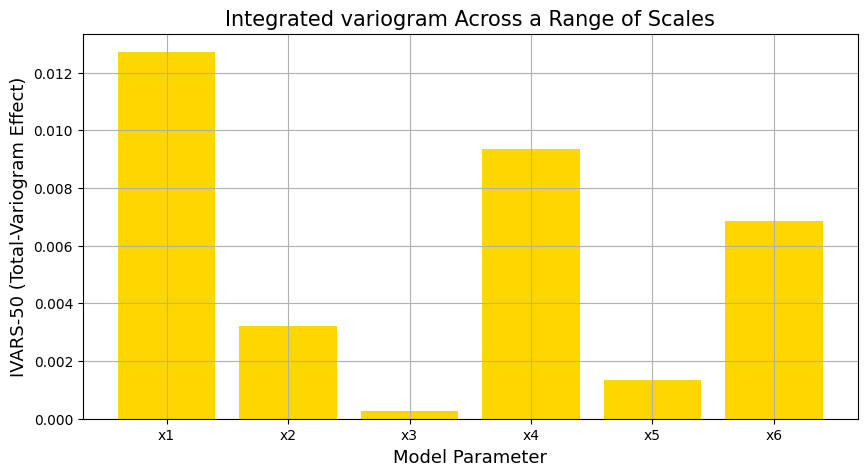

In [9]:
ivars_scale = 0.3 # Choose the scale range of interest, e.g., 0.1, 0.3, or 0.5

cols = experiment_1.parameters.keys()                     
fig_bar = plt.figure(figsize=(10,5))
plt.gca().bar(cols, experiment_1.ivars.loc[pd.IndexSlice[ ivars_scale ]][cols], color='gold')
plt.gca().set_title (r'Integrated variogram Across a Range of Scales', fontsize = 15)
plt.gca().set_ylabel(r'IVARS-50 (Total-Variogram Effect)', fontsize = 13)
plt.gca().set_xlabel(r'Model Parameter', fontsize=13)
plt.gca().grid()
plt.gca().set_yscale('linear')

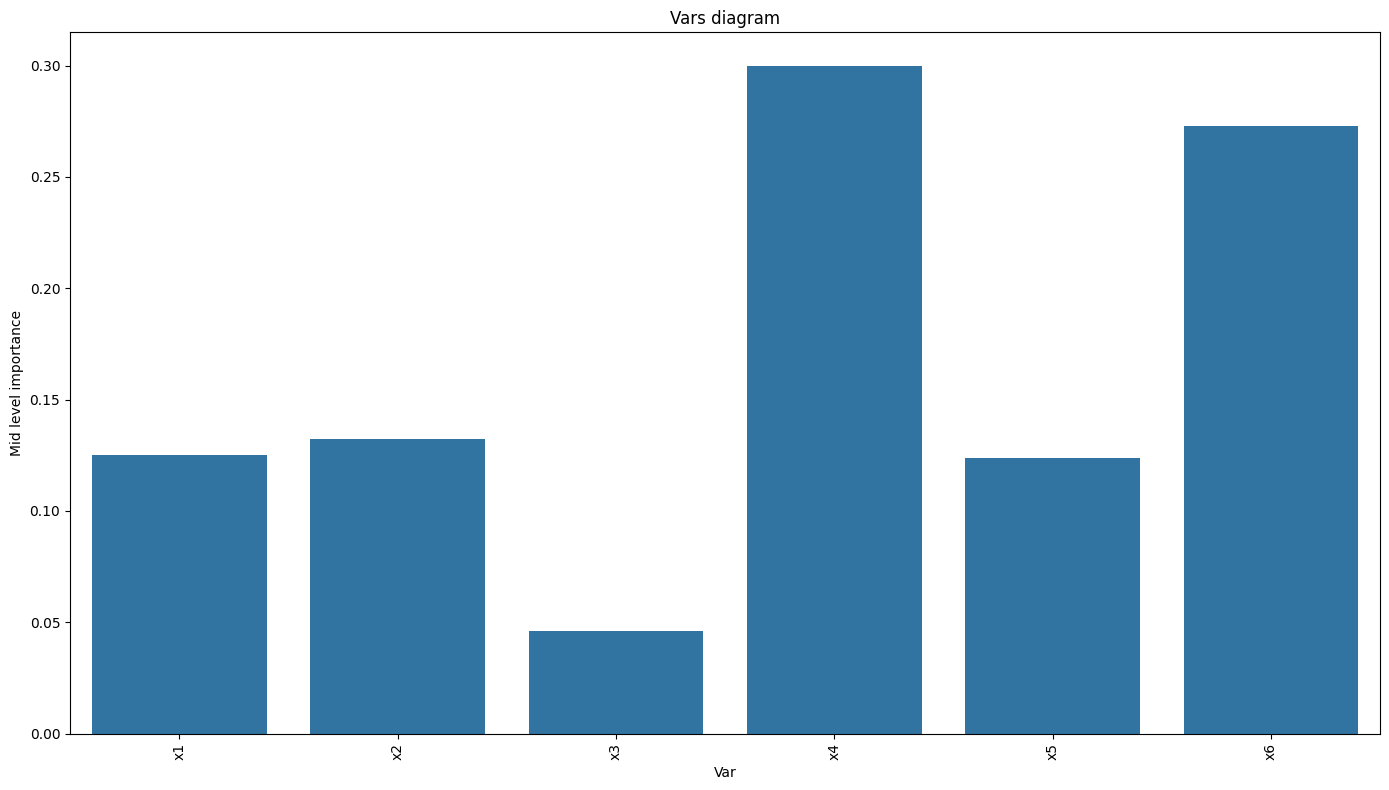

In [8]:
data = pd.DataFrame(experiment.ratios, index=[h])
# data = data.drop(data.columns[-1], axis=1) # Dropping lipid after


# Plotting the ratios
plt.figure(figsize=(14, 8))
sns.barplot(x=data.columns, y=data.iloc[0])
plt.xticks(rotation=90)
plt.title('Vars diagram')
plt.xlabel('Var')
plt.ylabel('Mid level importance')
plt.tight_layout()

plt.show()